<font size="3">__Team 3 Final Project: Ships in San Francisco__

Kelli Byrne, Elizabeth Haddad, Runze Wang

December 15, 2021</font>

________
# 1.0 Problem Statement
________


There is a great need for data analysis within the image analysis realm. Being able to analyze images quickly and effectively becomes essential as technology advances - from detecting diseases off of a CT scan, to finding missing persons on CCTV. 

There is also huge potential for the shipping industry to benefit from image analysis in many ways. In this notebook we will be training a convolutional neural network (CNN) to identify ships using commercial satellite images of San Francisco Bay. The images we will be working with are available via [Kaggle](https://www.kaggle.com/rhammell/ships-in-satellite-imagery)) and includes a classification of ship and no ship. Others have already trained a CNN using the the existing classifications with more than a 99% accuracy, however in reality the classifications for no ship is not accurate because approximately one third of those images are of partial ships. We hope to train a model to accurately recognize partial ships so they can also be considered as ships in decision making. This is most useful for private port opporators or governments so they can better identify potential clogs and better spread out import/export docking dates and times to prevent what happened recently in Long Beach (thedrive.com [link text](https://www.thedrive.com/the-war-zone/42612/satellite-images-show-massive-armada-of-idle-cargo-ships-waiting-to-dock-in-long-beach)). Such entities would be better served to leverage software that can identify the total number of ships plus half of total number of partial ships (assume 2 partials make a whole ship at the current zoom level).

________
# 2.0 Dataset
________


As the Kaggle website explains, the dataset consists of image chips extracted from Planet satellite imagery collected over the San Francisco Bay and San Pedro Bay areas of California and distributed as a JSON formatted text file shipsnet.json. 

The JSON contains:
*   ***data*** - list of 19200 integers with the first 6400 entries contain the red channel values, the next 6400 the green, and the final 6400 the blue
*   ***label*** - Values of 1 or 0, representing the "ship" class and "no-ship" classification
*   ***locations*** - list of latitude and longitude coordinates of the image center point
*   ***scene_ids*** - The unique identifier of the PlanetScope visual scene the image chip was extracted from 

In addition, we created our own second JSON file of partial ships data 'partial_ships_data.json'. It is a list of 436 unique latitude and longitude coordinate pairs that correspond to a partial ship images. To create this, we first manually examined all 4,000 images to isolate just those of partial ship images. We then manipulated this file list in EXCEL accordingly:
we first removed the filetype from the image name, then using the RIGHT function to extract the 37 characters at the end of the filename which correspond to the longitude and latitude values of the image, then did a find and replace to change underscores and spaces for commas and brackets as needed to create the correct JSON format.

## 2.1 Import Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
!pip install mgrs
import mgrs

     |████████████████████████████████| 47 kB 2.3 MB/s 


## 2.2 Import JSON

###2.2.1. If using local environment

You will need to download two .json files to your local directory, where this notebook is saved. The two files are listed below with the link to the Google Drive where they are stored. Please contact any of our team members if you have trouble downloading these files. Also be aware that one of these files is over 300 MB

shipsnet.json

partial_ship_data.json

https://drive.google.com/drive/folders/1NY1helYQlz3Af9mpOmJSy0nPBKtRYPMY?usp=sharing

In [2]:
#Load JSON from local root folder
##import os
##cwd = os.getcwd()
##shipdata = pd.read_json(os.path.join(cwd,"shipsnet.json"))
##partialshipdata = pd.read_json(os.path.join(cwd,"partial_ship_data.json"))

###2.2.2. If using Google Colab


In [3]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Save JSON data as variable
shipdata = pd.read_json('/content/drive/MyDrive/EM-0213/shipsnet/shipsnet.json')
partialshipdata = pd.read_json('/content/drive/MyDrive/EM-0213/partial_ship_data.json')


## 2.3 Read JSON

In [5]:
# Read the shipsnet.json to inspect the objects
shipdata.head()

,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007


In [6]:
# Read the partialshipdata.json to inspect the objects
partialshipdata.head()

,0,1
0,-122.337435,37.757290
1,-122.343896,37.750647
2,-122.327560,37.738252
3,-122.348008,37.759431
4,-122.349207,37.770253


________
# 3.0 Data Cleaning
________


Our first model identifies ships using using Tensorflow and Keras. To prepare the data for this model, we first renamed the "data" column to "pixel_data" and "labels" column to "ships" to be more specific. We then used lambda processing to convert pixel data to a NumPy array then divided by 255 to normalize the values. Finally we reshaped the data (assumes 80 pixels by 80 pixels and 3 color bands - RGB).

In [7]:
#rename data column
shipdata=shipdata.rename(columns={"data": "pixel_data"})

In [8]:
#rename labels column
shipdata=shipdata.rename(columns={"labels": "ships"})

In [9]:
# Normalize and reshape the image data
shipdata["normalized_pixel_data"] = shipdata["pixel_data"].apply(lambda x: (np.array(x) / 255).reshape(80, 80, 3))

Our second model identifies partial ships using similar methodology. For this we need a new column called partial_ship to stor classifications of 1 or 0 for 'partial ship' or 'no ship' respectively. After manually preparting our partial ships data JSON as described in 2.0 above, we use it lookup to see if a coordinate listed in shipsdata exists in partialshipsdata. If so, then convert partial_ship classification to 1. To make this easier to find a match, we first separate 'locations' data into separate 'latitude' and 'longitude' columns and convert to MSGR unit which is a single location string to work with.

In [10]:
# Create a new column of zeros to the shipdata dataframe called 'partial_ships'
shipdata['partial_ships'] = 0

In [11]:
# Rename data column
partialshipdata=partialshipdata.rename(columns={0: "latitude"})

In [12]:
# Rename data column
partialshipdata=partialshipdata.rename(columns={1: "longitude"})

In [13]:
# Split 'locations' column into two separate columns for 'latitude' and 'longitude'
shipdata[['latitude','longitude']] = pd.DataFrame(shipdata.locations.tolist(), index= shipdata.index)

In [14]:
# Convert latitude and longitude in shipdata to a float
shipdata['latitude'] = shipdata['latitude'].astype(float);
shipdata['longitude'] = shipdata['longitude'].astype(float);

In [15]:
# Convert latitude and longitude in partialshipdata to a float
partialshipdata['latitude'] = partialshipdata['latitude'].astype(float);
partialshipdata['longitude'] = partialshipdata['longitude'].astype(float);

In [16]:
# Convert latitude and longitude to MGRS for easier lookup and matching between the files; 
# This will assist us to assign partial ship classification to the correct impages in shipsdata
shipdata['mgrs'] = 0
partialshipdata['mgrs'] = 0

In [17]:
# Convert latitude and longitude in shipdata to MGRS
m = mgrs.MGRS()
shipdata.astype({'mgrs': 'object'}).dtypes
for x in range(len(shipdata)):
  a = m.toMGRS(shipdata.longitude[x],shipdata.latitude[x])
  shipdata.mgrs[x] = a

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [18]:
# Read shipdata head to confirm MGRS conversion
shipdata.head()

,pixel_data,ships,locations,scene_ids,normalized_pixel_data,partial_ships,latitude,longitude,mgrs
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47,"[[[0.3215686274509804, 0.34901960784313724, 0....",0,-118.225469,33.738037,11SLT8648133784
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e,"[[[0.2980392156862745, 0.29411764705882354, 0....",0,-122.332229,37.749176,10SEG5882878196
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06,"[[[0.49019607843137253, 0.4980392156862745, 0....",0,-118.142831,33.736016,11SLT9413433472
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a,"[[[0.4, 0.38823529411764707, 0.443137254901960...",0,-122.347843,37.766487,10SEG5743980107
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007,"[[[0.3058823529411765, 0.2980392156862745, 0.2...",0,-122.348524,37.758785,10SEG5738579252


In [19]:
# Convert longitude and latitude in partialshipdata to MGRS
m = mgrs.MGRS()
partialshipdata.astype({'mgrs': 'object'}).dtypes
for x in range(len(partialshipdata)):
  a = m.toMGRS(partialshipdata.longitude[x],partialshipdata.latitude[x])
  partialshipdata.mgrs[x] = a

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [20]:
# Read partialshipdata head to confirm MGRS conversion
partialshipdata.head()

,latitude,longitude,mgrs
0,-122.337435,37.757290,10SEG5836379093
1,-122.343896,37.750647,10SEG5779978352
2,-122.327560,37.738252,10SEG5924876987
3,-122.348008,37.759431,10SEG5743079324
4,-122.349207,37.770253,10SEG5731680524


In [22]:
# Assign a partial_ship value of 1 for rows that have a longitude value in list of partial_ships_longitude 
shipdata.loc[shipdata['mgrs'].isin(partialshipdata['mgrs']), "partial_ships"] = 1

In [23]:
# As a test, select rows whose longitude column value equals 10SEG5707378217 to see if it has a partial ship value of 1
df2=shipdata.loc[shipdata['mgrs'] == "10SEG5707378217"]
df2.head()

,pixel_data,ships,locations,scene_ids,normalized_pixel_data,partial_ships,latitude,longitude,mgrs
2167,"[81, 83, 86, 84, 82, 82, 85, 85, 88, 88, 85, 8...",0,"[-122.35214726919757, 37.749476005732866]",20170910_181216_1010,"[[[0.3176470588235294, 0.3254901960784314, 0.3...",1,-122.352147,37.749476,10SEG5707378217


In [24]:
# As a test, select rows whose longitude column value equals 10SEG4449172490 to see if it has a partial ship value of 0
df2=shipdata.loc[shipdata['mgrs'] == "10SEG4449172490"]
df2.head()

,pixel_data,ships,locations,scene_ids,normalized_pixel_data,partial_ships,latitude,longitude,mgrs
3999,"[122, 122, 126, 126, 142, 153, 174, 190, 185, ...",0,"[-122.49531387721586, 37.698557210117706]",20180206_184438_1043,"[[[0.47843137254901963, 0.47843137254901963, 0...",0,-122.495314,37.698557,10SEG4449172490


Additional checks reveal no missing or duplicate data (NOTE: we confirmed all image file names were unique via excel).

In [25]:
# Check to see if dataframe has any missing data
np.where(pd.isnull(shipdata))

(array([], dtype=int64), array([], dtype=int64))

________
# 4.0 Visualizations
________

Our RBG histogram visualization of a few images can be found below. We also have provided visuals throughout our analysis, including looking at the image inputs to the model and then looking at the saliency of the evaluated image after the model has been generated. 

Histograms of Images

In [26]:
# import json data to create numpy arrays for visual analysis
# same data set as above, however reloaded for simplicity
import json
# f = open(os.path.join(cwd,"shipsnet.json"))
f = open(r'/content/drive/MyDrive/EM-0213/shipsnet/shipsnet.json')
dataset = json.load(f) # load the json file
f.close()

In [27]:
data = np.array(dataset['data']).astype('uint8') # image data
ifship = np.array(dataset['labels']).astype('uint8') # labels is binary ship or no ship classification
n_spectrum = 3 # color channel (RGB)
width = 80
height = 80
data_reshape = data.reshape([-1, 3, 80, 80]).transpose([0,2,3,1]) # transpose data for image processing
data_reshape = data_reshape/255 # normalize the pixel data
print(data_reshape.shape) 
# check shape is compatible for plotting image, have 4000 images 80x80 pixels and 3 color channels

(4000, 80, 80, 3)


In [28]:
pd.Series(ifship).value_counts() # check how many ships/1 or no ships/0

0    3000
1    1000
dtype: int64

In [29]:
# create function to plot images and RBG histograms
# building off of https://www.kaggle.com/paultimothymooney/identifying-ships-in-satellite-images

def plothisto(a,b,c):
    '''a is the array we're looking at, b is the binary classification array,
    c is the index or row'''
    a = a[c] # call the image
    plt.figure(figsize=(10,5)) # establish plotting figures of image and histogram
    plt.subplot(1,2,1) # create subplots to show both image and histogram
    plt.imshow(a) # show image of ship or no ship, note this is the actual known result, not predicted
    plt.axis('off')
    plt.title('Ship' if b[c]==1 else 'Not A Ship') # check ship or no ship category to label image. ship is 1
    histo = plt.subplot(1,2,2) 
    histo.set_ylabel('Count') # histrogram axes labels
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30 
    # evaluate pixels for each red, green, blue intensities
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);

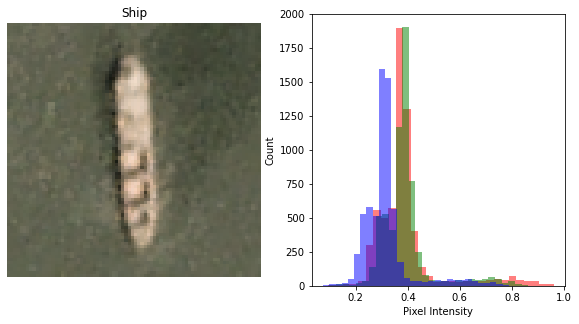

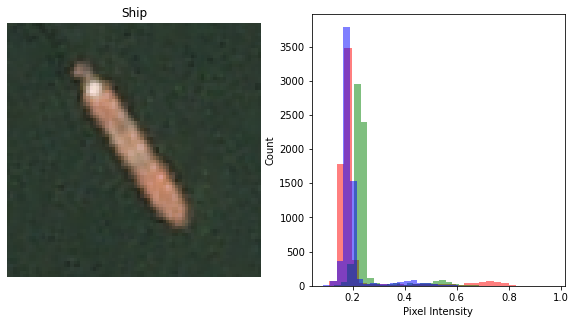

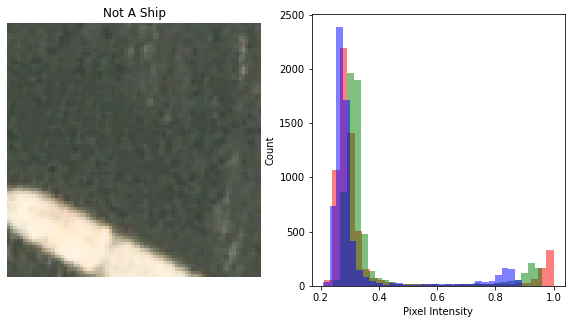

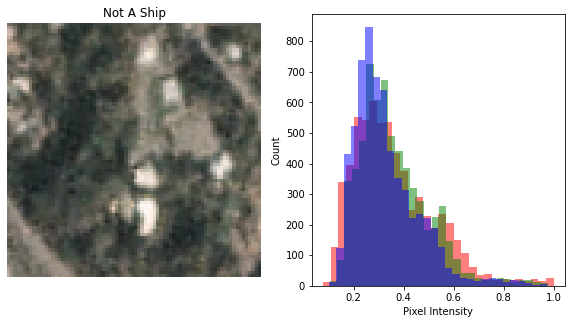

In [30]:
# look at the data for four random images (chosen random ship and no ship images)
plothisto(data_reshape,ifship,500)
plothisto(data_reshape,ifship,750)
plothisto(data_reshape,ifship,2500)
plothisto(data_reshape,ifship,3500)

We do not see any pattern withing the RBG histograms for ship vs no ship classification. We will look at salience after evaluating our models to see what the model sees in the image to understand how the model "looks" our images.

________
# 5.0 Model #1: Identifying Ships in Satellite Imagery
________


Model built upon tutorial here: https://towardsdatascience.com/classifying-ships-in-satellite-imagery-with-neural-networks-944024879651

We chose this model because we wanted to extend  a model that had a 99% accuracy for full ship. 

As a first step we split the data into training and testing sets and use a 80/20 split. The model will train on 3200 images and validate its results on 800 other images.

#### Issue with the code
After investigation, we found that the tutorial was processing the pixel data incorrectly, looking at a 3x3 B&W plot instead of the image as is. For our study, we want to analyze images as-is. Below you will see the transposed pixel data so image appears as-is.

In [31]:
# Define X and Y
X = shipdata["normalized_pixel_data"]
Y = shipdata["ships"]
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size=0.20, random_state=42)

In [32]:
# Transform the training and testing data into arrays for TensorFlow
X_train = np.array([x for x in X_train])
X_test = np.array([x for x in X_test])
Y_train = np.array([y for y in Y_train])
Y_test = np.array([y for y in Y_test])

1
0


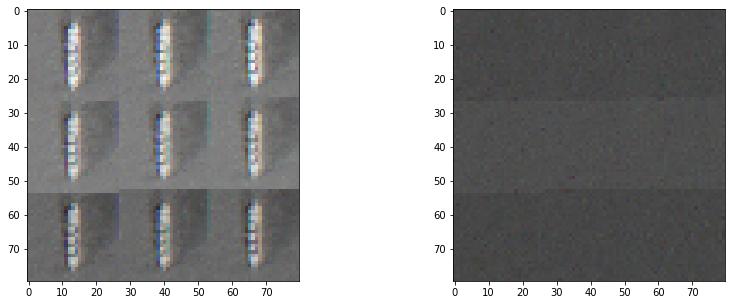

In [33]:
print(Y_test[750]) # see if image is ship or no ship classification in test and training arrays
print(Y_train[750])

# show images from pixel data for known ship and no ship
fig, axes = plt.subplots(1,2,figsize=(14,5)) # plot two images side by side
axes[0].imshow(X_test[750])
axes[1].imshow(X_train[750])

# tutorial did not process images in the best format
# Need to transpose pixels for image to be displayed/analyzed correctly

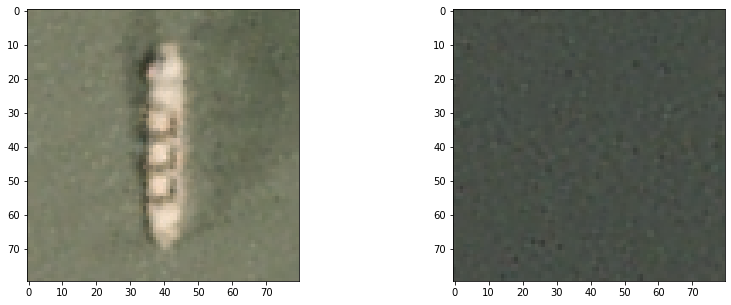

In [34]:
X_test = X_test.reshape([-1, 3, 80, 80]).transpose([0,2,3,1]) # transpose shape data
X_train = X_train.reshape([-1, 3, 80, 80]).transpose([0,2,3,1])
# verify images are processed correctly
fig, axes = plt.subplots(1,2,figsize=(14,5)) # plot two images side by side
axes[0].imshow(X_test[750])
axes[1].imshow(X_train[750])

# images look as they do as a png. OK to proceed with this data for the model

In [35]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Activation
# Starts the model with a sequential ANN
model = models.Sequential()

In [36]:
# Adds the first convulsion layer and follows up with max pooling
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(80, 80, 3)))
model.add(layers.MaxPooling2D((2, 2)))

In [37]:
# Add additional hidden layers
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [38]:
# Flattens the input into a 1D tensor
model.add(layers.Flatten())
# Makes the input more readable for classification
model.add(layers.Dense(64, activation='relu'))
# Classifies - ensure the input in the number of classes, indexed
# at 0
model.add(layers.Dense(1))
# Final activation function
model.add(Activation('sigmoid'))

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 78, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 39, 39, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 16384)             0

In [40]:
# Compile the model
# Use binary_crossentropy because there are only 2 classes present
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [41]:
# Train the model
gen_model = model.fit(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test))

Epoch 1/10
100/100 [==============================] - 20s 193ms/step - loss: 0.3939 - accuracy: 0.8462 - val_loss: 0.2481 - val_accuracy: 0.9000
Epoch 2/10
100/100 [==============================] - 19s 190ms/step - loss: 0.2228 - accuracy: 0.9172 - val_loss: 0.2589 - val_accuracy: 0.9013
Epoch 3/10
100/100 [==============================] - 19s 189ms/step - loss: 0.1767 - accuracy: 0.9337 - val_loss: 0.2015 - val_accuracy: 0.9112
Epoch 4/10
100/100 [==============================] - 19s 186ms/step - loss: 0.1350 - accuracy: 0.9481 - val_loss: 0.2270 - val_accuracy: 0.9013
Epoch 5/10
100/100 [==============================] - 19s 193ms/step - loss: 0.1041 - accuracy: 0.9619 - val_loss: 0.1035 - val_accuracy: 0.9712
Epoch 6/10
100/100 [==============================] - 19s 187ms/step - loss: 0.0881 - accuracy: 0.9681 - val_loss: 0.0843 - val_accuracy: 0.9700
Epoch 7/10
100/100 [==============================] - 19s 187ms/step - loss: 0.0810 - accuracy: 0.9716 - val_loss: 0.0996 - val_ac

In [42]:
# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix
predictions = model.predict(X_test)
print(classification_report(Y_test, predictions.round()))
cf_matrix = confusion_matrix(Y_test, predictions.round())
print(cf_matrix)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       591
           1       0.87      0.99      0.92       209

    accuracy                           0.96       800
   macro avg       0.93      0.97      0.95       800
weighted avg       0.96      0.96      0.96       800

[[560  31]
 [  3 206]]


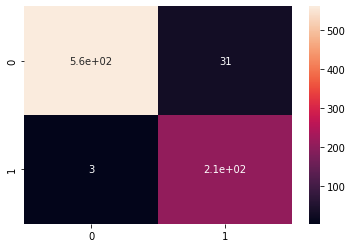

In [43]:
# plot heat map of correct and incorrect results for ship and no ship classifications
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

### Look at salience to understand what model sees


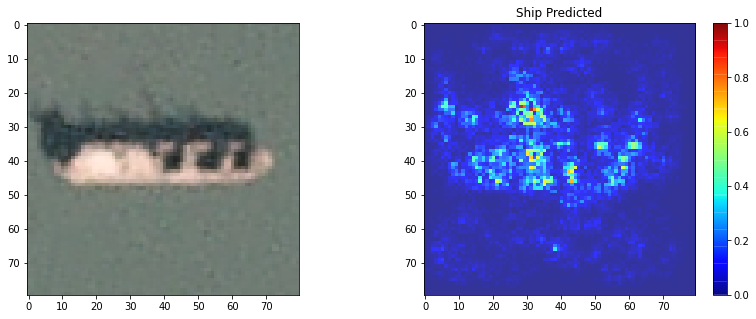

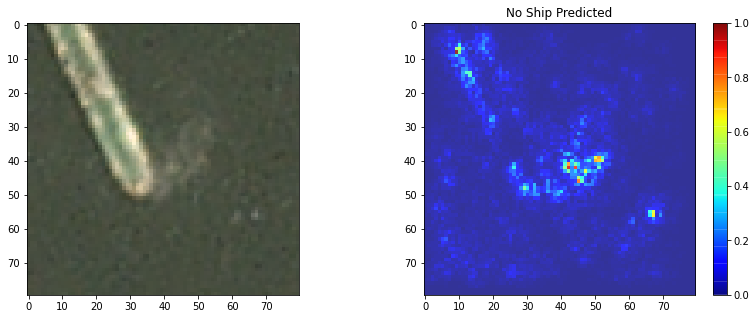

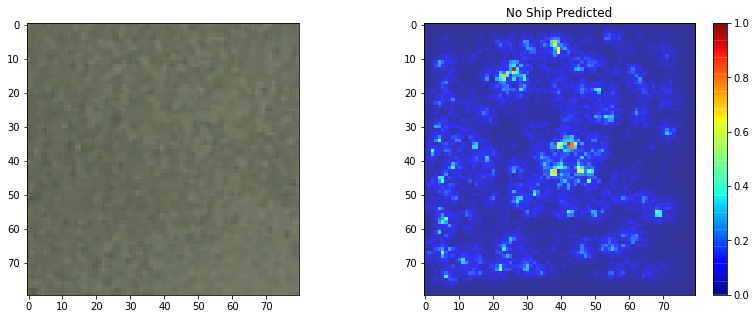

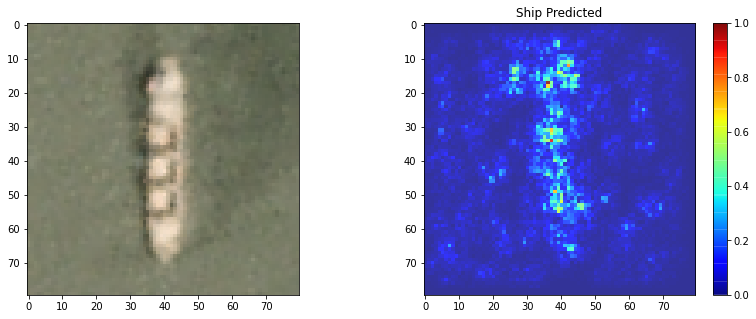

In [44]:
# Salience evaluation built upon tutorial here https://usmanr149.github.io/urmlblog/cnn/2020/05/01/Salincy-Maps.html

import keras

# creating function to show image being processed by the model and the 
# salience which the model sees of the image
def plotsal(a,b):
    '''a is the pixel array we're looking at, b is index'''
    _img = a[b] #recall an image to view saliency on

    img = keras.preprocessing.image.img_to_array(_img) # load the array
    img = img.reshape((1, *img.shape)) # match the required shape for model prediction
    y_pred_model = model.predict(img).round() # predict outcome of the model
    y_result = 'Ship' if y_pred_model==1 else 'Not A Ship' # want to show what the model predicts for the saliency image
    #print("Predicted value is " + str(y_pred_model1) + " so model predicts " + y_result + " is present .")
    images = tf.Variable(img, dtype=float) 

    with tf.GradientTape() as tape:
        pred = model(images, training=False)
        class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
        loss = pred[0][class_idxs_sorted[0]]
    # plot original images with saliency image and predicted result
    grads = tape.gradient(loss, images)
    dgrad_abs = tf.math.abs(grads)
    dgrad_max_ = np.max(dgrad_abs, axis=3)[0]
    arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
    grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    axes[0].imshow(_img)
    plt.title('Ship Predicted' if y_pred_model==1 else 'No Ship Predicted')
    i = axes[1].imshow(grad_eval,cmap="jet",alpha=0.8)
    fig.colorbar(i)

plotsal(X_test,100)
plotsal(X_test,200)
plotsal(X_test,300)
plotsal(X_test,750)

#### Salience Result of Model 1
Looking at the ship vs. no ship gradient plots, we see that there is recognition in a line shape for ships while the no ship images have a single point or points that are no in a line. This may be how the model recognizes when there is a ship in the image

________
# 6.0 Model #2: Identifying Partial Ships in Satellite Imagery
________

For Model #2, we will be looking at images only for images with partial ships or no ships. This model will see how well we can predict if a partial ship is present. 

In [45]:
# Define X and Y
data_10086 = shipdata.loc[shipdata['ships'] == 0] # load just the no ship images

X = data_10086["normalized_pixel_data"] # looking at the normalized data
Y = data_10086["partial_ships"] # look at the partial ship or no ship known data for each image
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size=0.20, random_state=42)

In [46]:
# Transform the training and testing data into arrays for TensorFlow
X_train = np.array([x for x in X_train])
X_test = np.array([x for x in X_test])
Y_train = np.array([y for y in Y_train])
Y_test = np.array([y for y in Y_test])

1
0


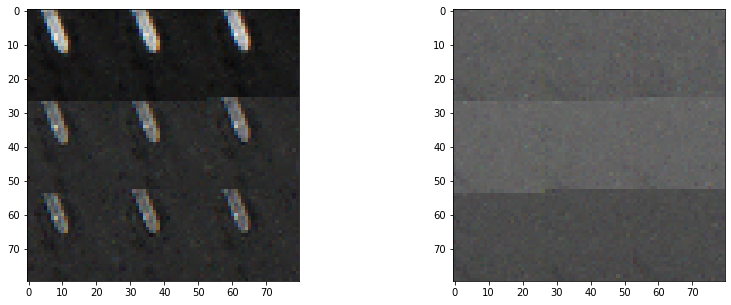

In [47]:
print(Y_test[200]) # see if image is ship or no ship classification in test and training arrays
print(Y_train[200])

# show images from pixel data for known ship and no ship
fig, axes = plt.subplots(1,2,figsize=(14,5)) # plot two images side by side
axes[0].imshow(X_test[200])
axes[1].imshow(X_train[200])

# tutorial did not process images in the best format
# Need to transpose pixels for image to be displayed/analyzed correctly

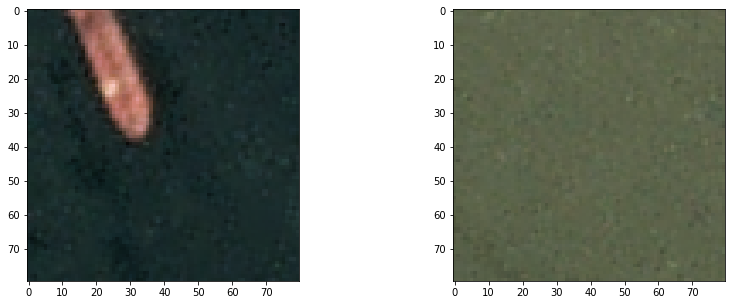

In [48]:
X_test = X_test.reshape([-1, 3, 80, 80]).transpose([0,2,3,1]) # transpose shape data
X_train = X_train.reshape([-1, 3, 80, 80]).transpose([0,2,3,1])
# verify images are processed correctly
fig, axes = plt.subplots(1,2,figsize=(14,5)) # plot two images side by side
axes[0].imshow(X_test[200])
axes[1].imshow(X_train[200])

# images look as they do as a png. OK to proceed with this data for the model

In [49]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Activation
# Starts the model with a sequential ANN
model2 = models.Sequential()

In [50]:
# Adds the first convulsion layer and follows up with max pooling
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(80, 80, 3)))
model2.add(layers.MaxPooling2D((2, 2)))

In [51]:
# Add additional hidden layers
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [52]:
# Flattens the input into a 1D tensor
model2.add(layers.Flatten())
# Makes the input more readable for classification
model2.add(layers.Dense(64, activation='relu'))
# Classifies - ensure the input in the number of classes, indexed
# at 0
model2.add(layers.Dense(1))
# Final activation function
model2.add(Activation('sigmoid'))

In [53]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 78, 78, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 39, 39, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 18, 18, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 flatten_1 (Flatten)         (None, 16384)            

In [54]:
# Compile the model
# Use binary_crossentropy because there are only 2 classes present
model2.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [55]:
# Train the model
gen_model2 = model2.fit(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test))

Epoch 1/10
75/75 [==============================] - 16s 195ms/step - loss: 0.4161 - accuracy: 0.8537 - val_loss: 0.3754 - val_accuracy: 0.8550
Epoch 2/10
75/75 [==============================] - 13s 179ms/step - loss: 0.3716 - accuracy: 0.8562 - val_loss: 0.3891 - val_accuracy: 0.8567
Epoch 3/10
75/75 [==============================] - 13s 179ms/step - loss: 0.3594 - accuracy: 0.8600 - val_loss: 0.3593 - val_accuracy: 0.8600
Epoch 4/10
75/75 [==============================] - 14s 182ms/step - loss: 0.3313 - accuracy: 0.8621 - val_loss: 0.3293 - val_accuracy: 0.8567
Epoch 5/10
75/75 [==============================] - 15s 205ms/step - loss: 0.3046 - accuracy: 0.8721 - val_loss: 0.3013 - val_accuracy: 0.8550
Epoch 6/10
75/75 [==============================] - 14s 189ms/step - loss: 0.2854 - accuracy: 0.8842 - val_loss: 0.3117 - val_accuracy: 0.8633
Epoch 7/10
75/75 [==============================] - 14s 181ms/step - loss: 0.2654 - accuracy: 0.8888 - val_loss: 0.2857 - val_accuracy: 0.8683

In [56]:
# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix
predictions_1 = model2.predict(X_test)
print(classification_report(Y_test, predictions_1.round()))
cf_matrix_1 = confusion_matrix(Y_test, predictions_1.round())
print(cf_matrix_1)

              precision    recall  f1-score   support

           0       0.90      0.95      0.92       513
           1       0.56      0.37      0.44        87

    accuracy                           0.87       600
   macro avg       0.73      0.66      0.68       600
weighted avg       0.85      0.87      0.85       600

[[488  25]
 [ 55  32]]


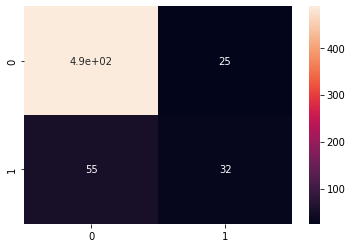

In [57]:
import seaborn as sns
sns.heatmap(cf_matrix_1, annot=True)

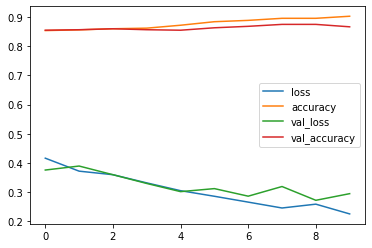

In [58]:
pd.DataFrame(gen_model2.history).plot()

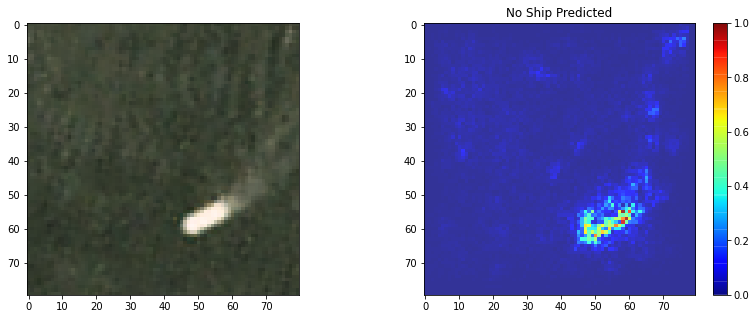

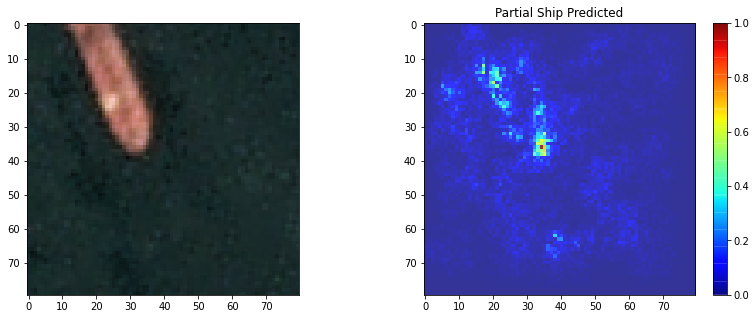

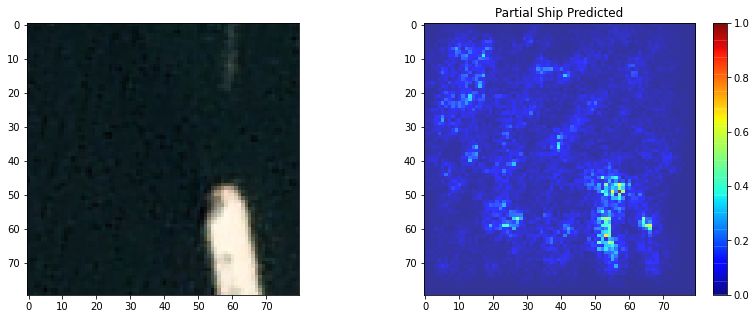

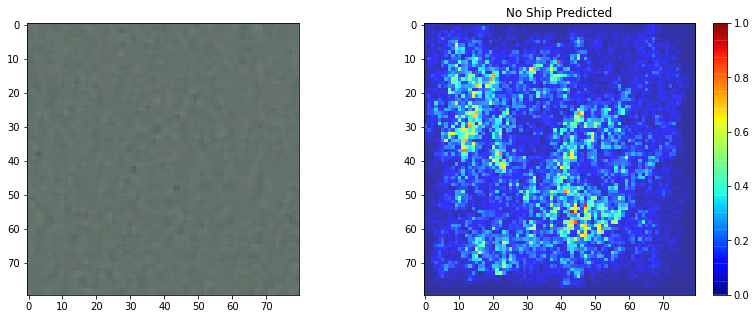

In [59]:
# looking at salience for model 2
# similar to salience function for model 1 except 1 is partial ship instead of ship

def plotsal(a,b):
    '''a is the pixel array we're looking at, b is index'''
    _img = a[b] #recall an image to view saliency on

    img = keras.preprocessing.image.img_to_array(_img) # load the array
    img = img.reshape((1, *img.shape)) # match the required shape for model prediction
    y_pred_model = model2.predict(img).round() # predict outcome of the model
    y_result = 'Ship' if y_pred_model==1 else 'Not A Ship'
    #print("Predicted value is " + str(y_pred_model1) + " so model predicts " + y_result + " is present .")
    images = tf.Variable(img, dtype=float) 

    with tf.GradientTape() as tape:
        pred = model2(images, training=False)
        class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
        loss = pred[0][class_idxs_sorted[0]]
    
    grads = tape.gradient(loss, images)
    dgrad_abs = tf.math.abs(grads)
    dgrad_max_ = np.max(dgrad_abs, axis=3)[0]
    arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
    grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    axes[0].imshow(_img)
    plt.title('Partial Ship Predicted' if y_pred_model==1 else 'No Ship Predicted')
    i = axes[1].imshow(grad_eval,cmap="jet",alpha=0.8)
    fig.colorbar(i)

plotsal(X_test,100)
plotsal(X_test,200)
plotsal(X_test,250)
plotsal(X_test,300)


________
# 7.0 Ethical Considerations
________

While we hope our project would help mitigate ethical concerns, such as safety of employees, improvements in cargo shipment efficiencies, etc., we also must consider how our analysis may negatively impact people or the environment. 

Our project does not consider what type of ships are being analyzed in each image. Improving efficiencies of ships coming in and out of port could lead to an increase in environmentally harmful ships entering the area. A further step in this analysis could be detecting solar panels on ships or specific types of ships known to be energy efficient. That data could be used to push the shipping industry to take a hard look at their fleets and make the appropriate upgrades to lessen their environmental impact.

There is also a possible impact for job loss. There could be a person relying on a wage from a logistics company to analyze satellite images to improve shipping efficiencies. It’s also possible that this technology could be used to identify and help or hurt ships intentionally not communicating their location (refugee ships, war ships). We should do our part to make sure we understand how any algorithm we create will be used and who will be impacted.

Finally, we need to understand that the image data we are working with may be biased. We are only looking at images from one source and in one location. If using the same algorithm with a different set of images without considering the change in image quality or color palette, there may be incorrect data being used to make decisions that affect the supply chain. We also don’t have time tied to these images so we can’t be sure they represent the full range of ships to detect.


________
# 8.0 Conclusions
________


We put no ship and partial ship data through the same classifiers we had before to train our model. The new model had about an 87 percent accuracy. The classifiers that used to recognize ship vs no ship may be not suitable for partial ship and caused the accuracy to drop. One other matter is we did not separate all partial ship from no ship, and this may let the model to be confused.

Though it is not as accurate as the original model, it is definitely a solid start. The port operators can greatly benefit from this new model because the number of ships this model able to recognize is closer to reality. 

For future consideration, it might help to see if accuracy of partial ship recognition could be augmented with partial evidence. For example, with access to channel GIS polygons form a port boundaries dataset we could do a lookup to create additional key value pairs for each image to determine if their lat/long falls “in channel” (1) or  “out of channel” (0), since most large objects in a channel are ships. 

Another possible area for exploration beyond accuracy is the prediction of volume/density of ship in the future. The current image set are from a limited date range, but we potentially download additional images from a wider date range from Plant.